In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from zipfile import ZipFile
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Loading Datasets

In [2]:
def read_model_dataset(chosen, combine_cats = False):
    non_features = ['u_id', 'p_id']
    demo_cols = []
    predictor = ['pur']
    file_name = ""

    if chosen == 0:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    elif chosen == 1:
        file_name = "some_one_hot.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'occ_0', 'occ_1', 'occ_10',
               'occ_11', 'occ_12', 'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17',
               'occ_18', 'occ_19', 'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5',
               'occ_6', 'occ_7', 'occ_8', 'occ_9', 'city_A', 'city_B', 'city_C']
    elif chosen == 2:
        file_name = "all_one_hot.csv"
        demo_cols = ['gender', 'married', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
               'age_5', 'age_6', 'occ_0', 'occ_1', 'occ_10', 'occ_11', 'occ_12',
               'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17', 'occ_18', 'occ_19',
               'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_7', 'occ_8',
               'occ_9', 'city_0', 'city_1', 'city_2',
               'years_in_city_0', 'years_in_city_1', 'years_in_city_2',
               'years_in_city_3', 'years_in_city_4']
    elif chosen == 3:
        file_name = "BlackFriday.csv"
        non_features = ['User_ID', 'Product_ID']
        demo_cols = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
        predictor = ['Purchase']
    else:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    
    if combine_cats and (chosen != 0 or chosen != 3):
        modeldf = pd.read_csv("inputs/p_combined_" + file_name)
    else:
        modeldf = pd.read_csv("inputs/" + file_name)
    # modeldf = modeldf.drop(non_features, axis = 1)
    # line below removes purchase outliers from modeldf
    # modeldf = modeldf[modeldf["pur"] < modeldf["pur"].quantile(0.99)]
    
    X = modeldf.drop(predictor, axis = 1).drop(non_features, axis = 1)
    y = modeldf[predictor]
    
    return modeldf, X, y, predictor, demo_cols

In [3]:
# minimal_preprocess = 0
# some_one_hot = 1
# all_one_hot = 2
# raw_df = 3
# defaults to minimal_preprocess

modeldf, X, y, predictor, demo_cols = read_model_dataset(0, combine_cats = False)
modeldf.head()

,u_id,p_id,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
0,1,69042,0,0,10,0,2,0,3,0,0,8370
1,1,248942,0,0,10,0,2,0,1,6,14,15200
2,1,87842,0,0,10,0,2,0,12,0,0,1422
3,1,85442,0,0,10,0,2,0,12,14,0,1057
4,2,285442,1,6,16,2,4,0,8,0,0,7969


In [4]:
raw_df , _, _, raw_predictor, raw_demo_cols = read_model_dataset(3, combine_cats = False)
raw_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# Analysis/Exploration

In [5]:
modeldf.describe()

,u_id,p_id,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
count,537577.000000,537577.000000,537577.000000,537577.000000,537577.00000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000
mean,2991.847028,173319.290509,0.754087,2.494755,8.08271,1.040567,1.859458,0.408797,5.295546,6.784907,3.871773,9333.859853
std,1714.392695,101715.607539,0.430627,1.352583,6.52412,0.759627,1.289828,0.491612,3.750701,6.211618,6.265963,4981.022133
min,1.000000,142.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,185.000000
25%,1495.000000,96742.000000,1.000000,2.000000,2.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,5866.000000
50%,3031.000000,165842.000000,1.000000,2.000000,7.00000,1.000000,2.000000,0.000000,5.000000,5.000000,0.000000,8062.000000
75%,4417.000000,256742.000000,1.000000,3.000000,14.00000,2.000000,3.000000,1.000000,8.000000,14.000000,8.000000,12073.000000
max,6040.000000,370642.000000,1.000000,6.000000,20.00000,2.000000,4.000000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [6]:
print("Unique values for each column\n---------------\n")

for col in modeldf.columns:
    print("%s: %d" % (col, modeldf[col].nunique()))

Unique values for each column
---------------

u_id: 5891
p_id: 3623
gender: 2
age: 7
occ: 21
city: 3
years_in_city: 5
married: 2
p_cat_1: 18
p_cat_2: 18
p_cat_3: 16
pur: 17959


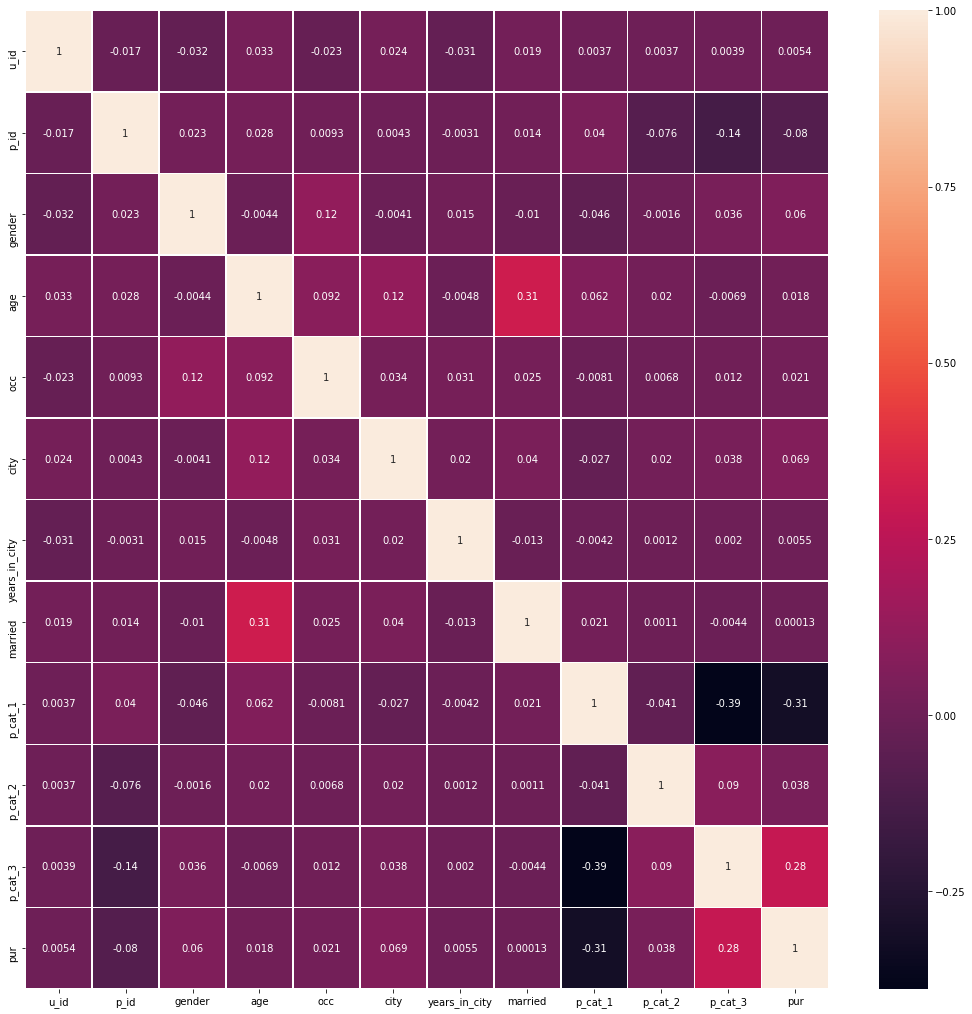

In [7]:
fig, axes = plt.subplots(figsize=(18, 18))
sns.heatmap(modeldf.corr(), annot = True, linewidths=.5)

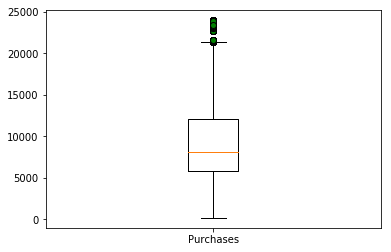

In [8]:
props = dict(marker='.', markerfacecolor='green', markersize=12, linestyle='none')
plt.boxplot(modeldf['pur'], flierprops = props)
plt.xticks([1], ['Purchases'])
plt.show()

## Overview

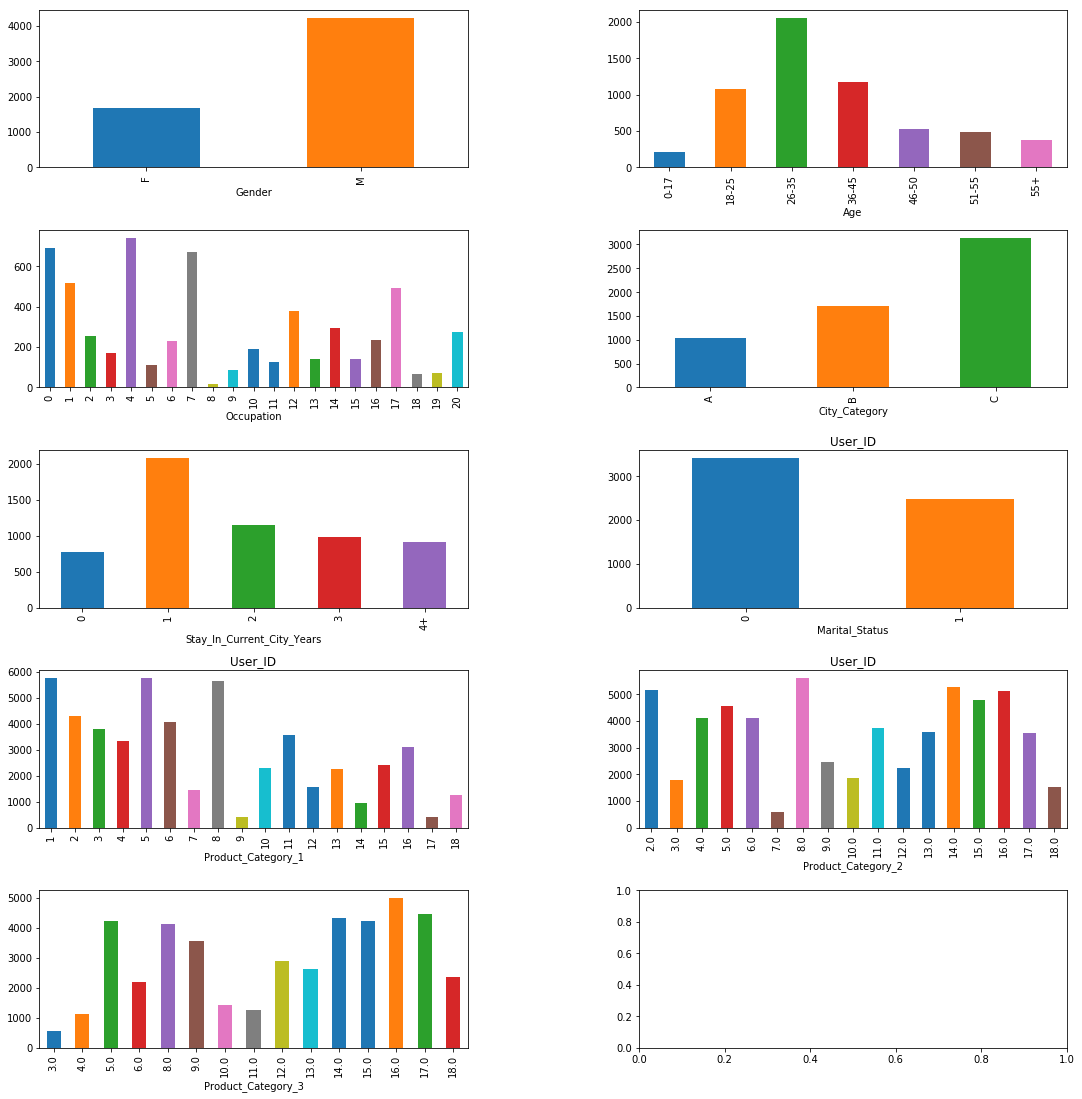

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(wspace=0.4,hspace=0.4)

raw_df['User_ID'].groupby(raw_df['Gender']).nunique().plot(kind='bar',ax=axes[0,0])
raw_df['User_ID'].groupby(raw_df['Age']).nunique().plot(kind='bar',ax=axes[0,1])
raw_df['User_ID'].groupby(raw_df['Occupation']).nunique().plot(kind='bar',ax=axes[1,0])
raw_df['User_ID'].groupby(raw_df['City_Category']).nunique().plot(kind='bar',ax=axes[1,1])
raw_df['User_ID'].groupby(raw_df['Stay_In_Current_City_Years']).nunique().plot(kind='bar',ax=axes[2,0])
raw_df['User_ID'].groupby(raw_df['Marital_Status']).nunique().plot(subplots=True,kind='bar',ax=axes[2,1])
raw_df['User_ID'].groupby(raw_df['Product_Category_1']).nunique().plot(subplots=True,kind='bar',ax=axes[3,0])
raw_df['User_ID'].groupby(raw_df['Product_Category_2']).nunique().plot(subplots=True,kind='bar',ax=axes[3,1])
raw_df['User_ID'].groupby(raw_df['Product_Category_3']).nunique().plot(kind='bar',ax=axes[4,0])

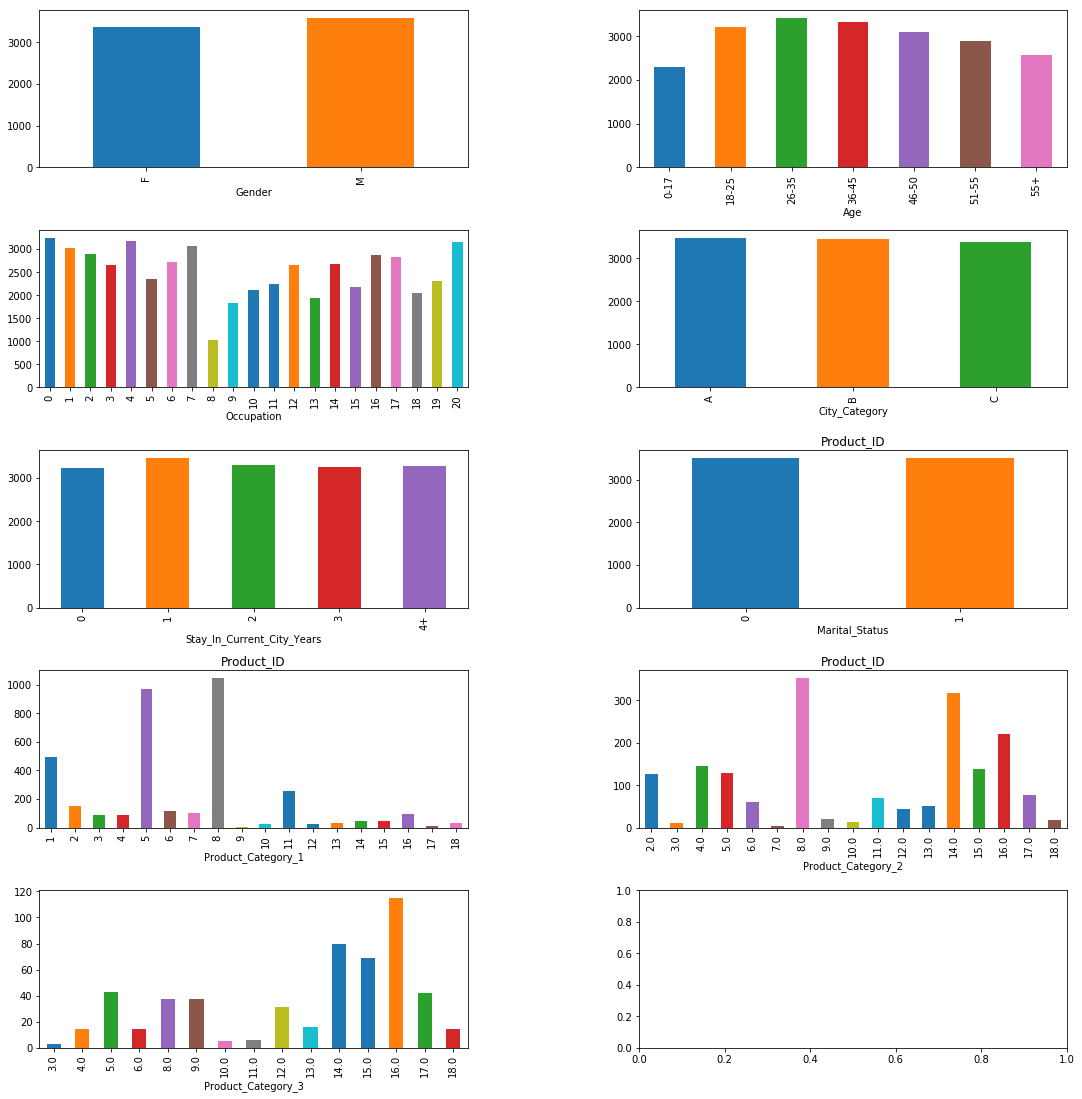

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(wspace=0.4,hspace=0.4)

raw_df['Product_ID'].groupby(raw_df['Gender']).nunique().plot(kind='bar',ax=axes[0,0])
raw_df['Product_ID'].groupby(raw_df['Age']).nunique().plot(kind='bar',ax=axes[0,1])
raw_df['Product_ID'].groupby(raw_df['Occupation']).nunique().plot(kind='bar',ax=axes[1,0])
raw_df['Product_ID'].groupby(raw_df['City_Category']).nunique().plot(kind='bar',ax=axes[1,1])
raw_df['Product_ID'].groupby(raw_df['Stay_In_Current_City_Years']).nunique().plot(kind='bar',ax=axes[2,0])
raw_df['Product_ID'].groupby(raw_df['Marital_Status']).nunique().plot(subplots=True,kind='bar',ax=axes[2,1])
raw_df['Product_ID'].groupby(raw_df['Product_Category_1']).nunique().plot(subplots=True,kind='bar',ax=axes[3,0])
raw_df['Product_ID'].groupby(raw_df['Product_Category_2']).nunique().plot(subplots=True,kind='bar',ax=axes[3,1])
raw_df['Product_ID'].groupby(raw_df['Product_Category_3']).nunique().plot(kind='bar',ax=axes[4,0])

## Demographics

In [11]:
def plot(group, column, plot):
    ax=plt.figure(figsize=(12,6))
    plt.ylabel(column)
    raw_df.groupby(group)[column].sum().plot(plot)
    
def plot_pie(column):
    plot = raw_df[column].value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%')
    plot.legend()

### Gender

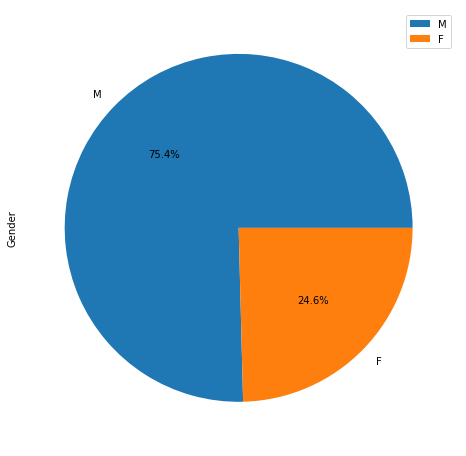

In [12]:
plot_pie('Gender')

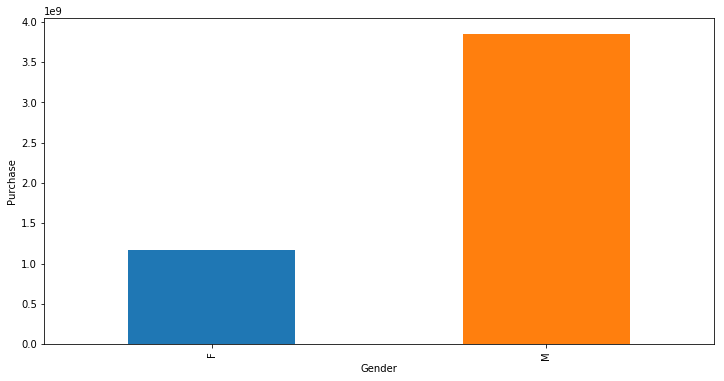

In [13]:
plot('Gender','Purchase','bar')

### Age

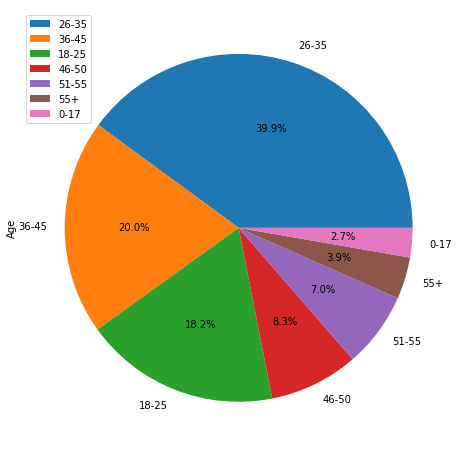

In [14]:
plot_pie('Age')

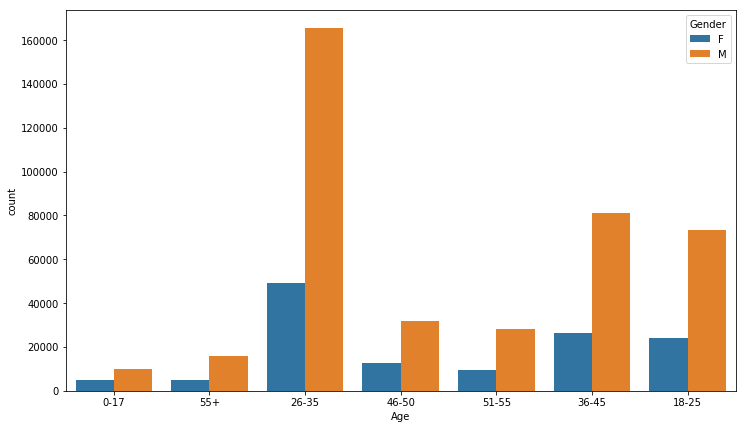

In [15]:
fig1, ax1 = plt.subplots(figsize=(12,7))
sns.countplot(raw_df['Age'],hue=raw_df['Gender'])

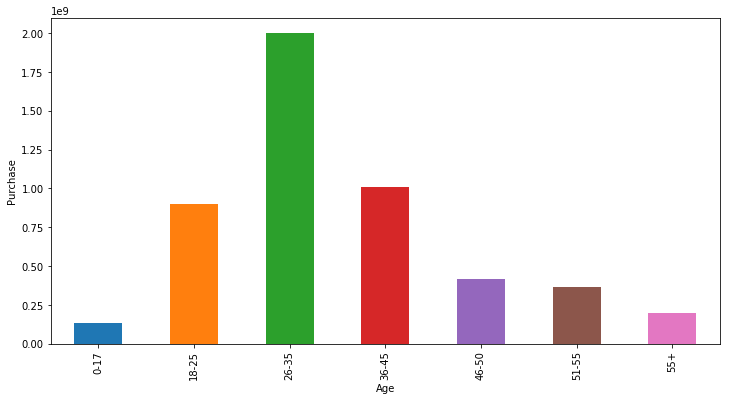

In [16]:
plot('Age','Purchase','bar')

### Occupation

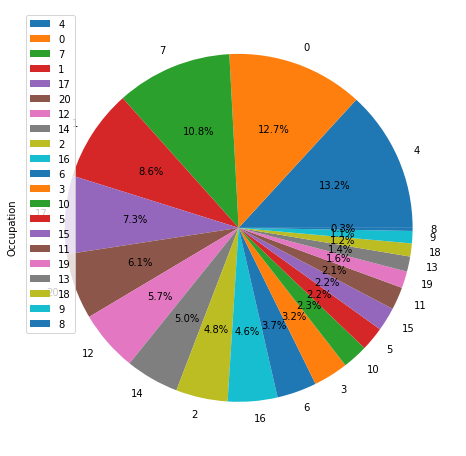

In [17]:
plot_pie('Occupation')

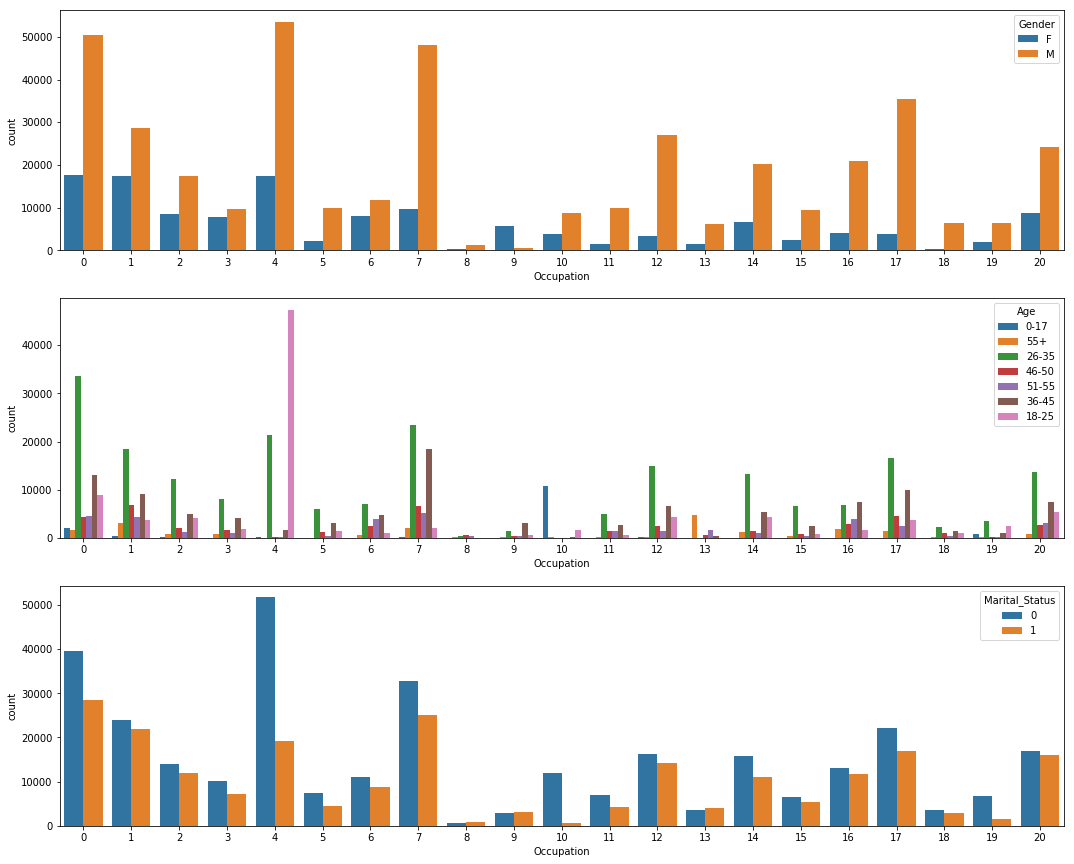

In [18]:
fig1, ax1 = plt.subplots(3, 1, figsize=(18,15))
sns.countplot(raw_df['Occupation'],hue=raw_df['Gender'], ax = ax1[0])
sns.countplot(raw_df['Occupation'],hue=raw_df['Age'], ax = ax1[1])
sns.countplot(raw_df['Occupation'],hue=raw_df['Marital_Status'], ax = ax1[2])

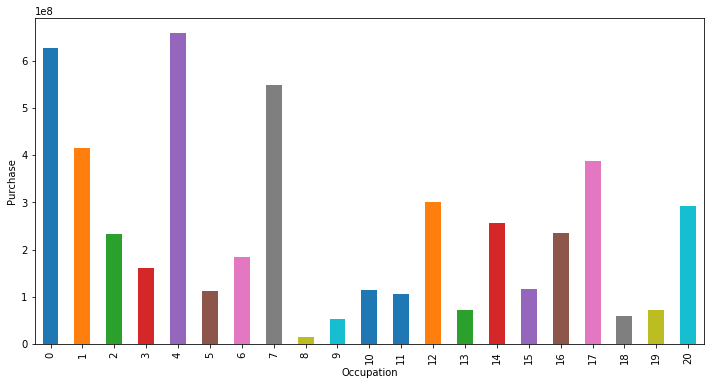

In [19]:
plot('Occupation','Purchase','bar')

### City

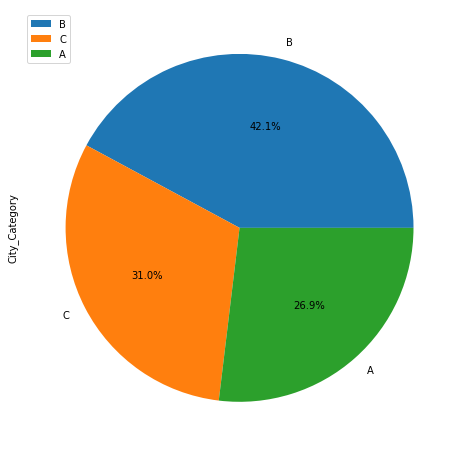

In [20]:
plot_pie('City_Category')

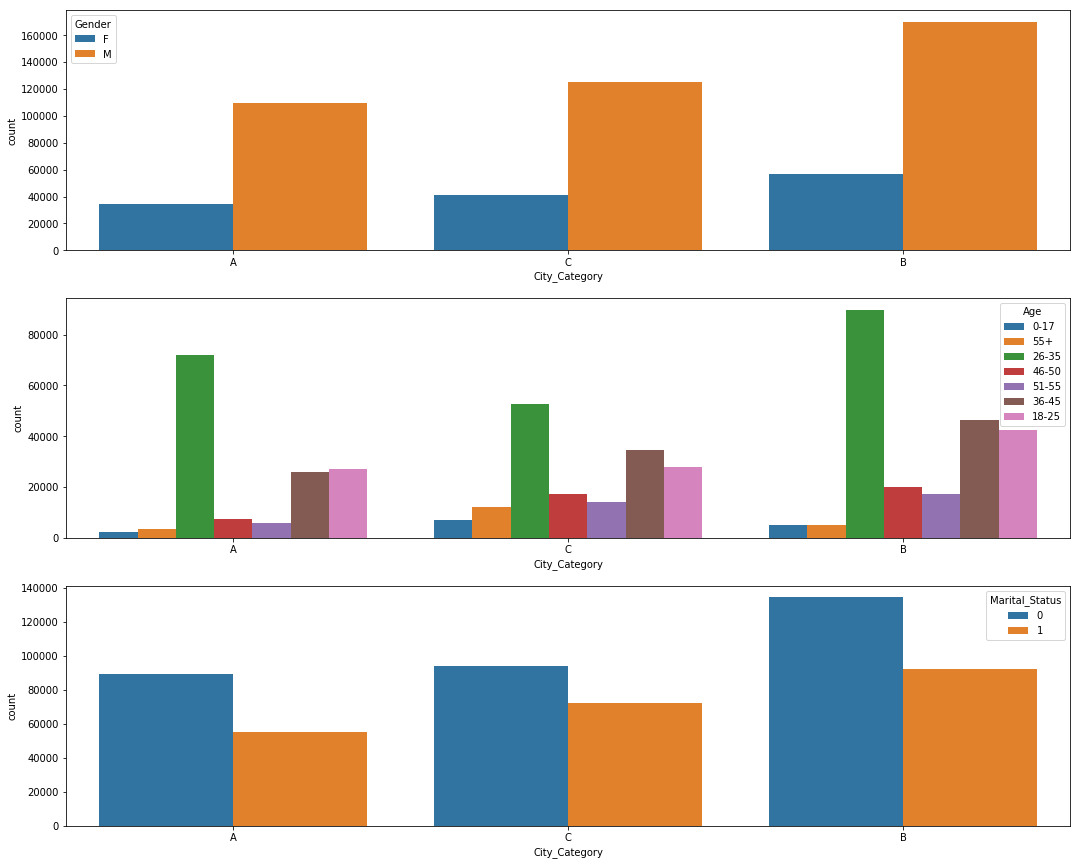

In [21]:
fig1, ax1 = plt.subplots(3, 1, figsize=(18,15))
sns.countplot(raw_df['City_Category'],hue=raw_df['Gender'], ax = ax1[0])
sns.countplot(raw_df['City_Category'],hue=raw_df['Age'], ax = ax1[1])
sns.countplot(raw_df['City_Category'],hue=raw_df['Marital_Status'], ax = ax1[2])

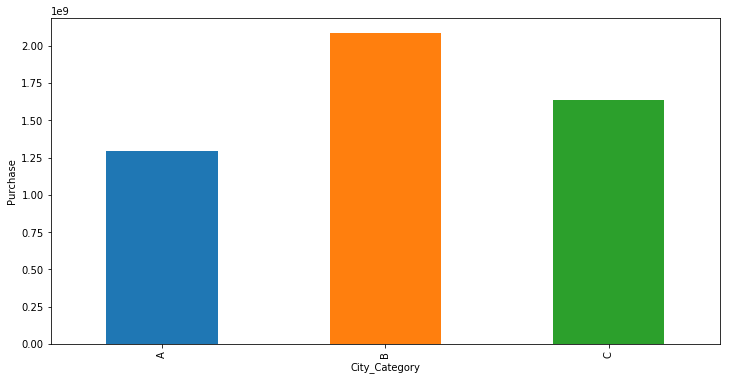

In [22]:
plot('City_Category','Purchase','bar')

### Years in City

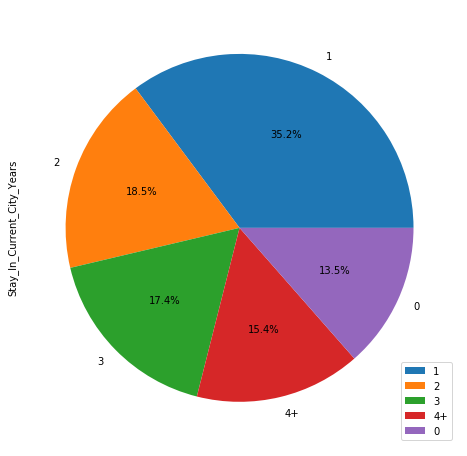

In [23]:
plot_pie('Stay_In_Current_City_Years')

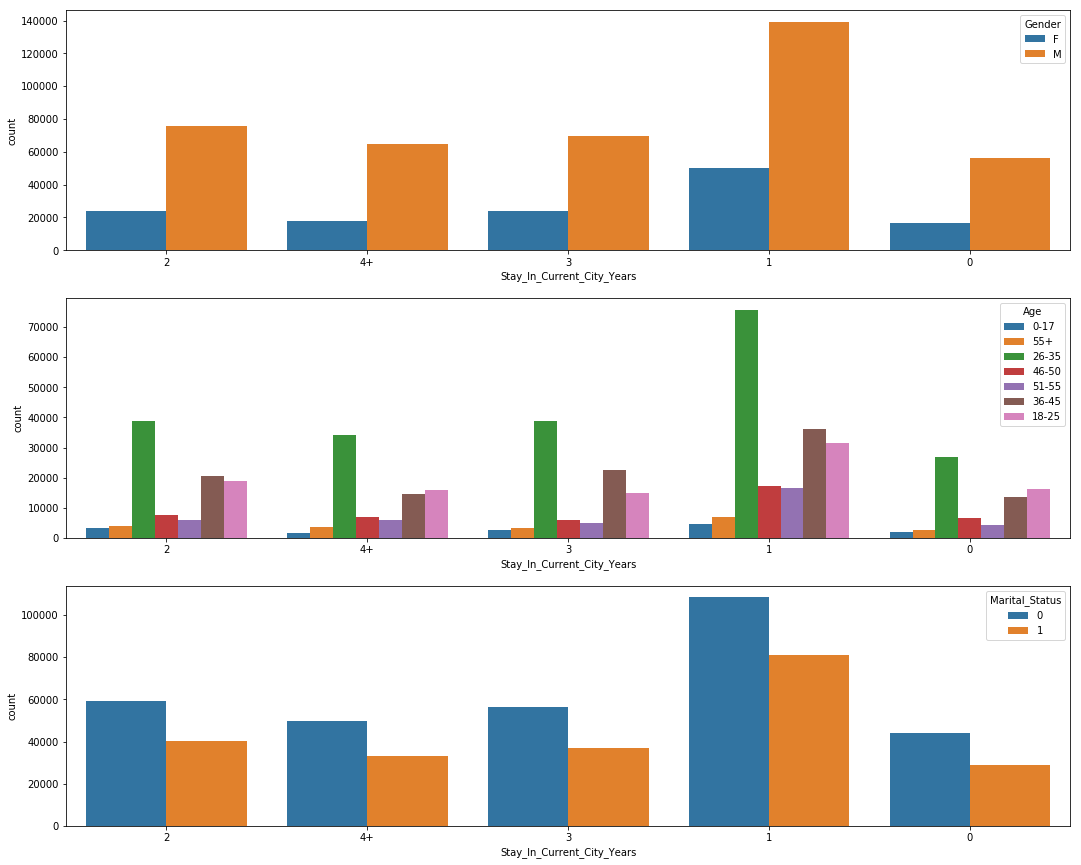

In [24]:
fig1, ax1 = plt.subplots(3, 1, figsize=(18,15))
sns.countplot(raw_df['Stay_In_Current_City_Years'],hue=raw_df['Gender'], ax = ax1[0])
sns.countplot(raw_df['Stay_In_Current_City_Years'],hue=raw_df['Age'], ax = ax1[1])
sns.countplot(raw_df['Stay_In_Current_City_Years'],hue=raw_df['Marital_Status'], ax = ax1[2])

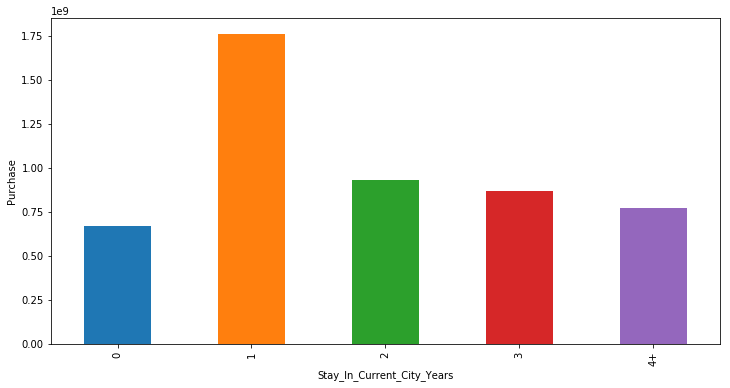

In [25]:
plot('Stay_In_Current_City_Years','Purchase','bar')

### Marital Status

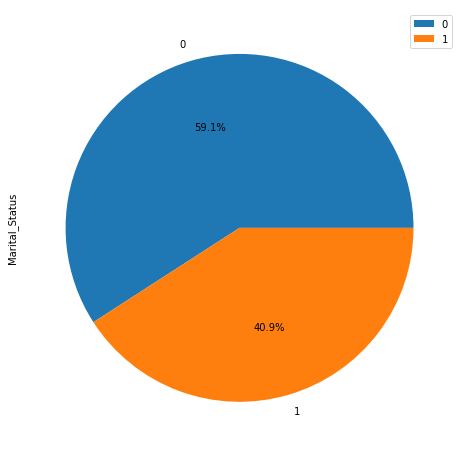

In [26]:
plot_pie('Marital_Status')

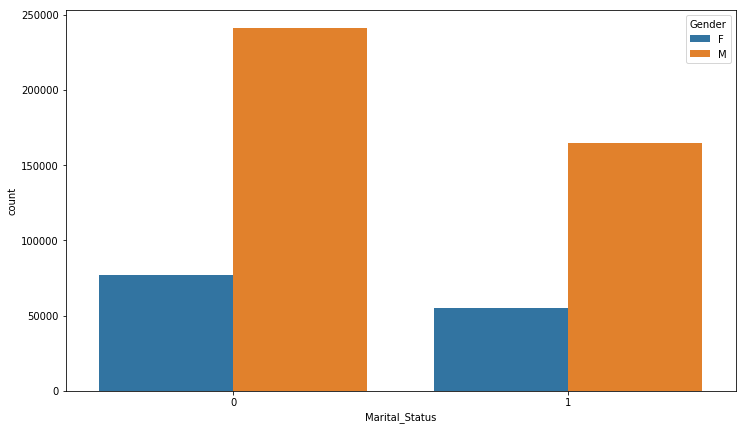

In [27]:
fig1, ax1 = plt.subplots(figsize=(12,7))
sns.countplot(raw_df['Marital_Status'],hue=raw_df['Gender'])

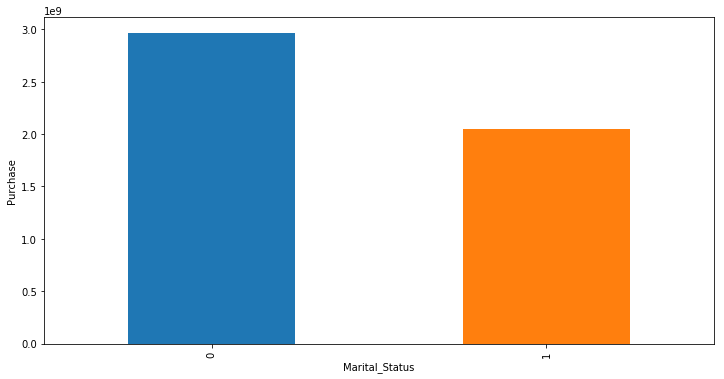

In [28]:
plot('Marital_Status','Purchase','bar')

In [29]:
top_k = 3

top = raw_df.groupby('Product_ID')['Purchase'].sum().nlargest(top_k)
topdf = pd.DataFrame({'Product_ID': top.index, 'Purchase': top.values})
topdf = raw_df.loc[raw_df['Product_ID'].isin(topdf['Product_ID'].values)]

In [30]:
# splits datasets based on demographics specified
def create_custom_clusters(dataframe, cats):
    temp = [dataframe]

    first = True
    for split in cats:
        other_temp = []
        for other in temp:
            other_temp.append([other[other[split] == x] for x in other[split].unique()])
        if first:
            temp = other_temp[0]
            first = False
        else:
            temp = []
            for other in other_temp:
                for some_other in other:
                    if not some_other.empty:
                        temp.append(some_other)

    return sorted(temp, key=len)

Product ID P00255842


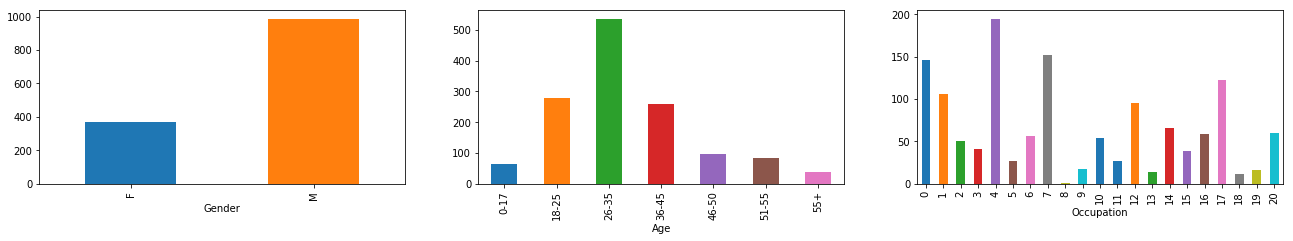

Product ID P00025442


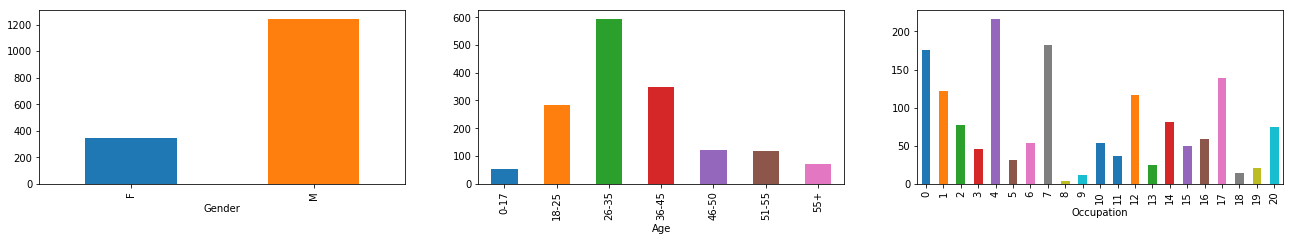

Product ID P00110742


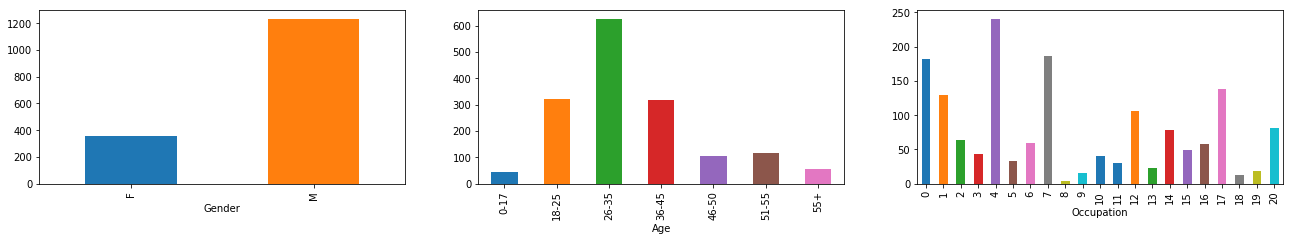

---------------------------------------------------------------------------------------------------------------------------

Product ID P00255842


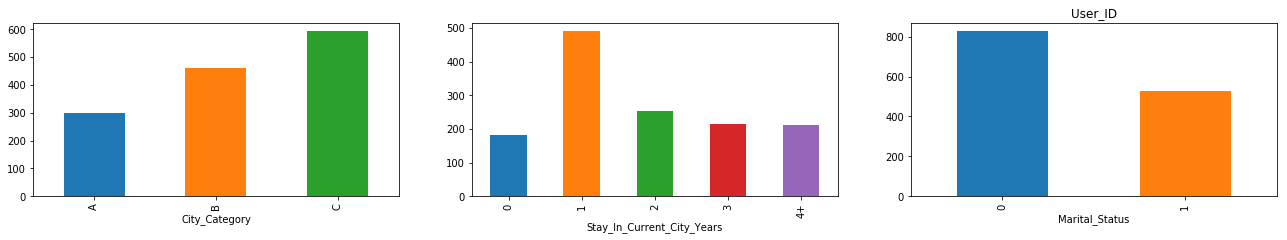

Product ID P00025442


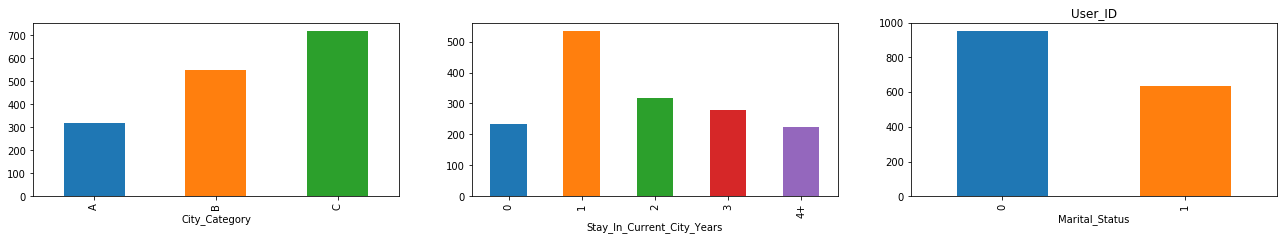

Product ID P00110742


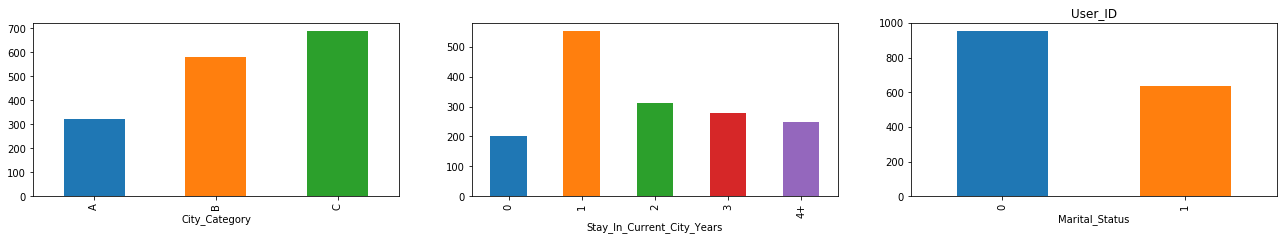

In [31]:
custom_clusters = create_custom_clusters(topdf, ['Product_ID'])
for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Product ID %s' % temp.iloc[0]['Product_ID'])
    temp['User_ID'].groupby(temp['Gender']).nunique().plot(kind='bar',ax=axes[0])
    temp['User_ID'].groupby(temp['Age']).nunique().plot(kind='bar',ax=axes[1])
    temp['User_ID'].groupby(temp['Occupation']).nunique().plot(kind='bar',ax=axes[2])
    plt.show()
print("---------------------------------------------------------------------------------------------------------------------------\n")
for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Product ID %s' % temp.iloc[0]['Product_ID'])
    temp['User_ID'].groupby(temp['City_Category']).nunique().plot(kind='bar',ax=axes[0])
    temp['User_ID'].groupby(temp['Stay_In_Current_City_Years']).nunique().plot(kind='bar',ax=axes[1])
    temp['User_ID'].groupby(temp['Marital_Status']).nunique().plot(subplots=True,kind='bar',ax=axes[2])
    plt.show()

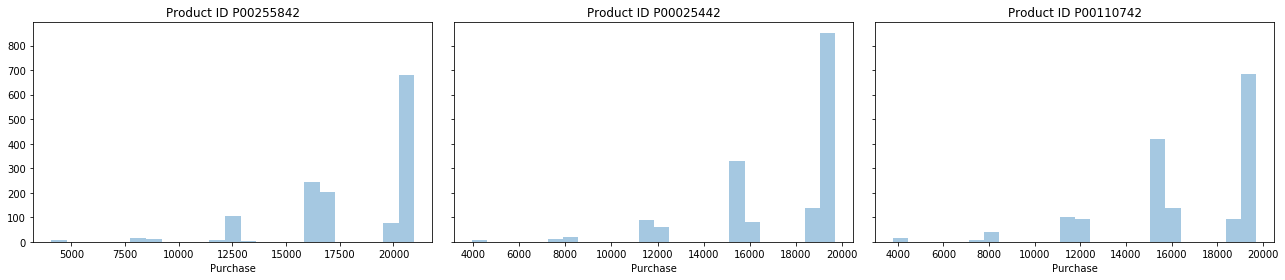

In [32]:
n_cols = 3
n_rows = 1
fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i].set_title('Product ID %s' % cluster.iloc[0]['Product_ID'])
    sns.distplot(cluster['Purchase'], kde = False, ax = axs[i])
plt.tight_layout()

# Clustering

In [33]:
# Generates k-means cluster datasets
# returns whole dataframe with clusters and cluster split dataframes
def create_cluster_modeldfs(X_frame, y, frame_demo_cols, n_clusters = 3):
    kmeansdf = StandardScaler().fit_transform(X_frame[frame_demo_cols])
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 30, precompute_distances = True, n_jobs = -1).fit(kmeansdf) # testing shows that 2-3 clussters works the best
    cluster_nums = kmeans.predict(kmeansdf)

    # Single dataset for clusters
    X_cl = pd.DataFrame(cluster_nums, columns = ['cluster_num']).join(X_frame)
    
    # Seperate datasets based on clusters
    temp = X_cl.join(y)
    X_cls = [temp[temp['cluster_num'] == x] for x in range(max(temp['cluster_num']) + 1)]
    X_cls = [cluster.drop('cluster_num', axis = 1) for cluster in X_cls]
    
    # one hot encode cluster numbers
    ranges = pd.unique(pd.Series(X_cl['cluster_num']))
    ranges.sort()
    mapped = ['cluster_num_' + str(x) for x in ranges]
    saved_cluster_num = X_cl['cluster_num']
    X_cl['cluster_num'] = X_cl['cluster_num'].map(dict(zip(ranges, mapped)))
    one_hot = pd.get_dummies(X_cl['cluster_num'])
    #X_cl = X_cl.drop('cluster_num', axis = 1)
    X_cl['cluster_num'] = saved_cluster_num
    X_cl = X_cl.join(one_hot) 
    
    return X_cl, X_cls

In [34]:
def plot_PCA_clusters(X_pca_clusters):
    colors = ['green', 'blue', 'red']
    labels = ['cluster 0', 'cluster 1', 'cluster 2']

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')

    for cluster, color, label in zip(X_pca_clusters, colors, labels):
        ax.scatter(cluster['pc_0'], cluster['pc_1'],  cluster['pc_2'], color = color, label = label)

    ax.set_xlabel("pc_0")
    ax.set_ylabel("pc_1")
    ax.set_zlabel("pc_2")
    ax.legend()
    plt.show()
    
def plot_FA_clusters(X_fa_clusters):
    colors = ['green', 'blue', 'red']
    labels = ['cluster 0', 'cluster 1', 'cluster 2']

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')

    for cluster, color, label in zip(X_fa_clusters, colors, labels):
        ax.scatter(cluster['f0'], cluster['f1'],  cluster['f2'], color = color, label = label)

    ax.set_xlabel("f0")
    ax.set_ylabel("f1")
    ax.set_zlabel("f2")
    ax.legend()
    plt.show()
    

In [35]:
modeldf, X, y, predictor, demo_cols = read_model_dataset(1, combine_cats = False)

## Principle Componenet Analysis

In [36]:
def create_pca_modeldf(X, model_cols, per_variance_captured = .95):
    
    all_X = X
    X = X[model_cols]
    X = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(StandardScaler().fit_transform(X))
    plt.subplots(2,1, figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(pca.explained_variance_ratio_, '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Pro. Variance Explained")
    ax1 = plt.subplot(1,2,2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Pro. Variance Explained")
    plt.show()
    
    n_components = np.where(np.cumsum(pca.explained_variance_ratio_)>=per_variance_captured)[0][0] + 1
    print('%0.2f of variance explained by %d principal components' % (per_variance_captured, n_components))
    
    principalComponents = pca.transform(X)[:, 0:n_components]
    X_pca = pd.DataFrame(data = principalComponents, columns = ['pc_' + str(x) for x in range(n_components)])
    pca_cols = X_pca.columns
    X_pca = X_pca.join(all_X.drop(model_cols, axis = 1))
    
    return X_pca, pca_cols

def plot_top3pca(X_pca, color = 'blue'):
    start = 0
    n_cols = 3
    n_rows = 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows))
    for i, num in enumerate(range(start, start + 3)):
        axes = axs[i]
        first = 'pc_%d' % num
        second = 'pc_%d' % (num+1)
        axes.scatter(X_pca[first], X_pca[second], color = color)
        axes.set_xlabel(first)
        axes.set_ylabel(second)
    plt.show()
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca['pc_0'], X_pca['pc_1'],  X_pca['pc_2'], color = color)

    ax.set_xlabel("pc_0")
    ax.set_ylabel("pc_1")
    ax.set_zlabel("pc_2")
    plt.show()


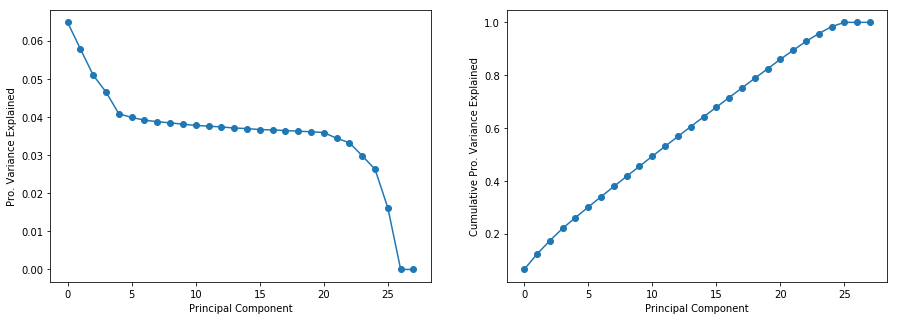

0.95 of variance explained by 24 principal components

Plotting top 3 PCAs


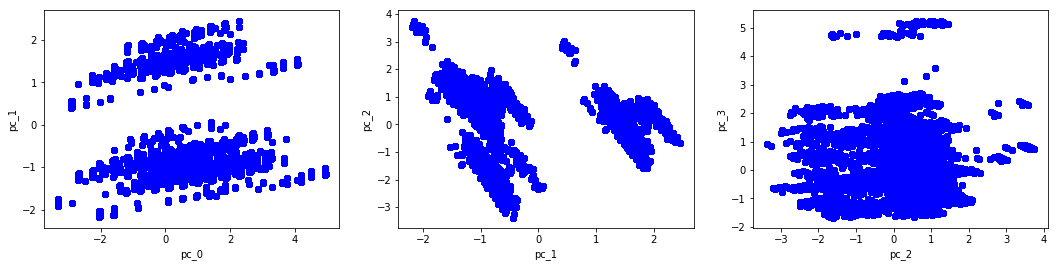

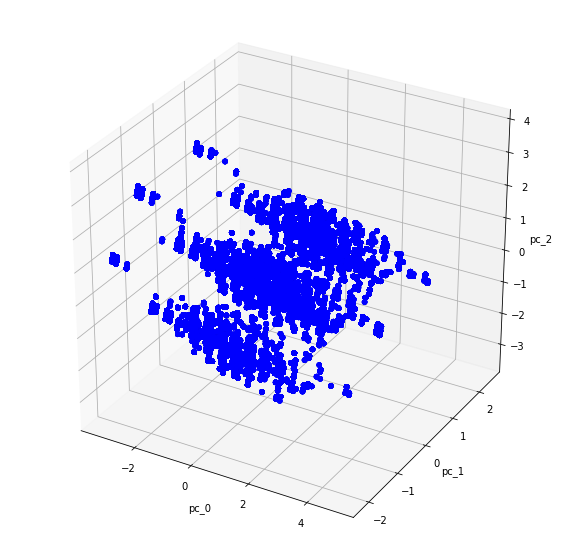

In [37]:
X_pca, pca_cols = create_pca_modeldf(X, demo_cols, per_variance_captured = .95)
print("\nPlotting top 3 PCAs")
plot_top3pca(X_pca)

Clustering Using PCAs

Done!


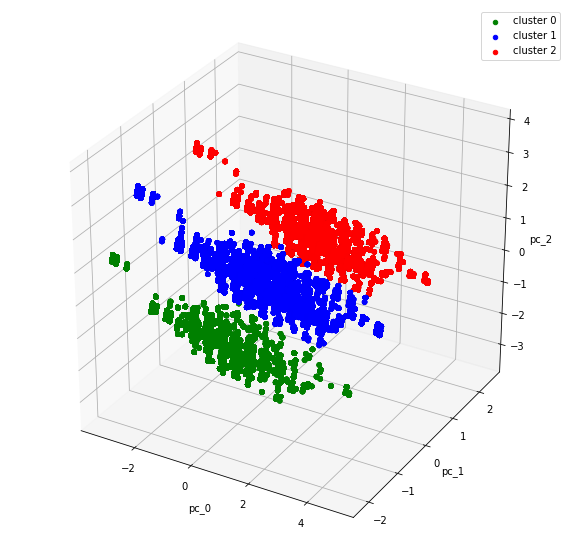

In [38]:
print("Clustering Using PCAs\n")
X_pca_cluster, X_pca_clusters = create_cluster_modeldfs(X_pca, y, pca_cols, n_clusters = 3)
print("Done!")
plot_PCA_clusters(X_pca_clusters)

## Factor Analysis

In [39]:
def create_fa_modeldf(X, model_cols, per_variance_captured = .95):
    
    all_X = X
    X = X[model_cols]
    X = StandardScaler().fit_transform(X)
    fa = FactorAnalysis()
    fa.fit(X)
    
    m = fa.components_
    n = fa.noise_variance_
    
    m1 = m**2
    m2 = np.sum(m1, axis = 1)
    
    pvar = (100*m2)/(np.sum(m2)+np.sum(n))
    pvar = pvar/np.cumsum(pvar)[len(pvar) - 1]
    
    plt.subplots(2,1, figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(pvar, '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Pro. Variance Explained")
    ax1 = plt.subplot(1,2,2)
    plt.plot(np.cumsum(pvar), '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Pro. Variance Explained")
    plt.show()
    
    n_components = np.where(np.cumsum(pvar)>=per_variance_captured)[0][0] + 1
    print('%0.2f of variance explained by %d principal components' % (per_variance_captured, n_components))
    
    components = fa.transform(X)[:, 0:n_components]
    X_fa = pd.DataFrame(data = components, columns = ['f' + str(x) for x in range(n_components)])
    fa_cols = X_fa.columns
    X_fa = X_fa.join(all_X.drop(model_cols, axis = 1))
    
    return X_fa, fa_cols

def plot_top3fa(X_fa, color = 'blue'):
    start = 0
    n_cols = 3
    n_rows = 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows))
    for i, num in enumerate(range(start, start + 3)):
        axes = axs[i]
        first = 'f%d' % num
        second = 'f%d' % (num+1)
        axes.scatter(X_fa[first], X_fa[second], color = color)
        axes.set_xlabel(first)
        axes.set_ylabel(second)
    plt.show()
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_fa['f0'], X_fa['f1'],  X_fa['f2'], color = color)

    ax.set_xlabel("f0")
    ax.set_ylabel("f1")
    ax.set_zlabel("f2")
    plt.show()

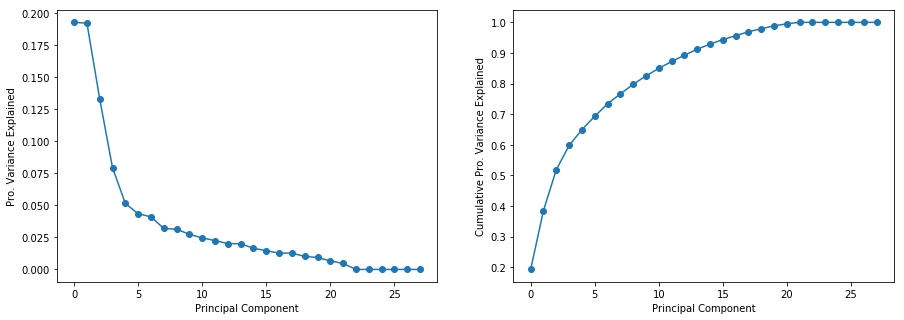

0.95 of variance explained by 17 principal components

Plotting top 3 FAs


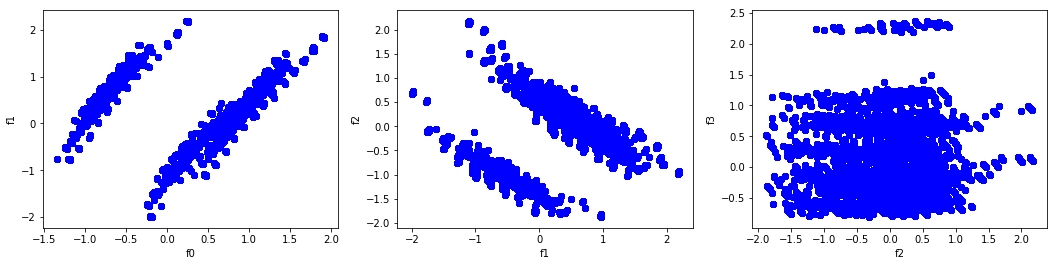

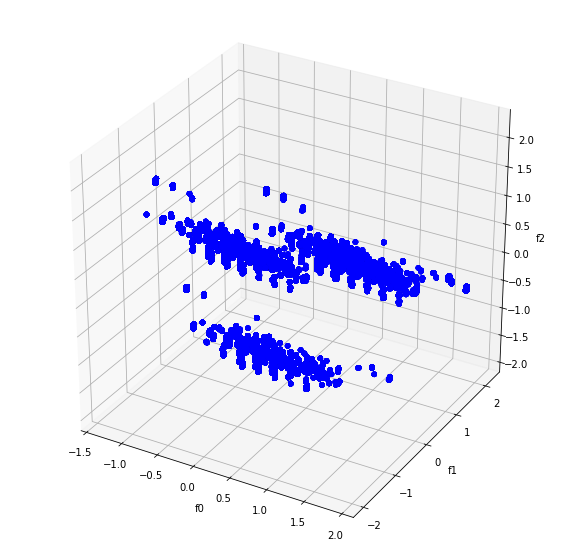

In [40]:
X_fa, fa_cols = create_fa_modeldf(X, demo_cols, per_variance_captured = .95)
print("\nPlotting top 3 FAs")
plot_top3fa(X_fa)

Clustering Using FA

Done!


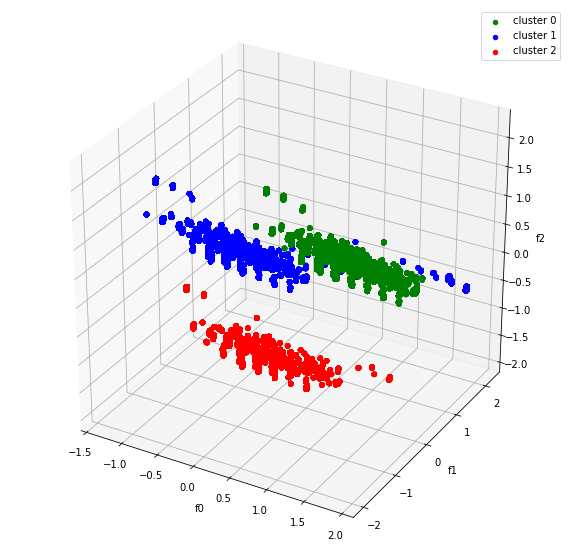

In [41]:
print("Clustering Using FA\n")
X_fa_cluster, X_fa_clusters = create_cluster_modeldfs(X_fa, y, fa_cols, n_clusters = 3)
print("Done!")
plot_FA_clusters(X_fa_clusters)

Cluster Number 2


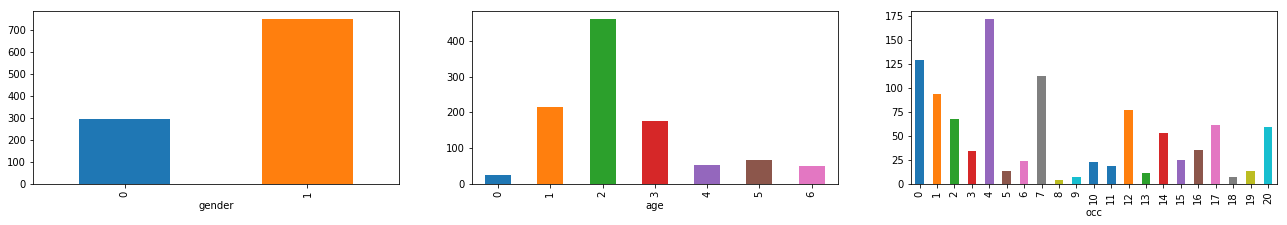

Cluster Number 0


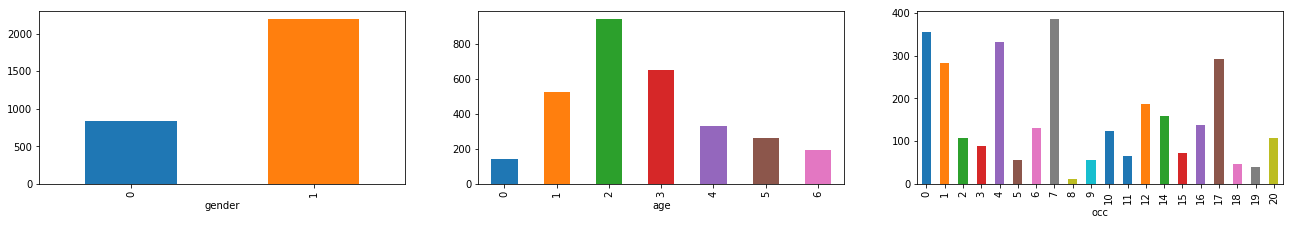

Cluster Number 1


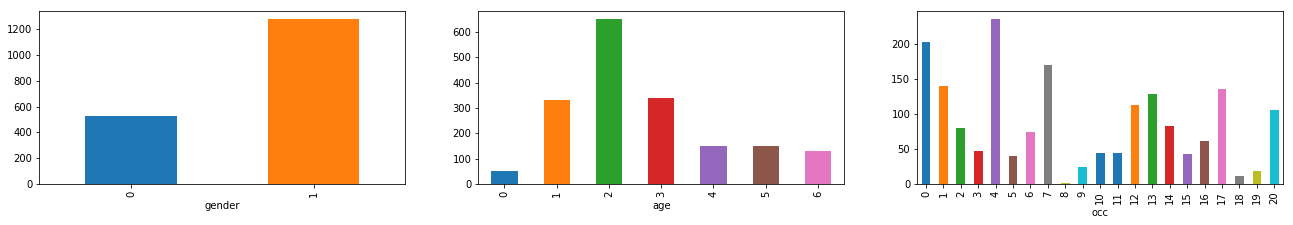

---------------------------------------------------------------------------------------------------------------------------

Cluster Number 2


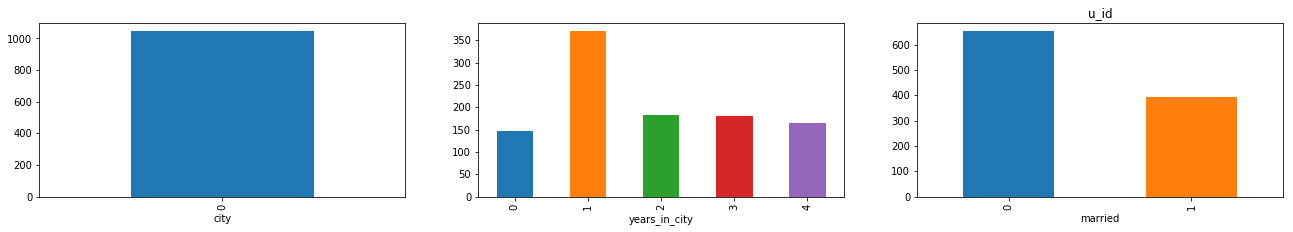

Cluster Number 0


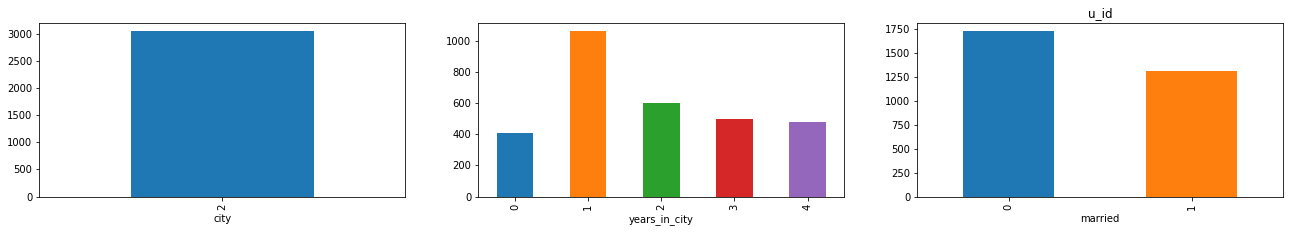

Cluster Number 1


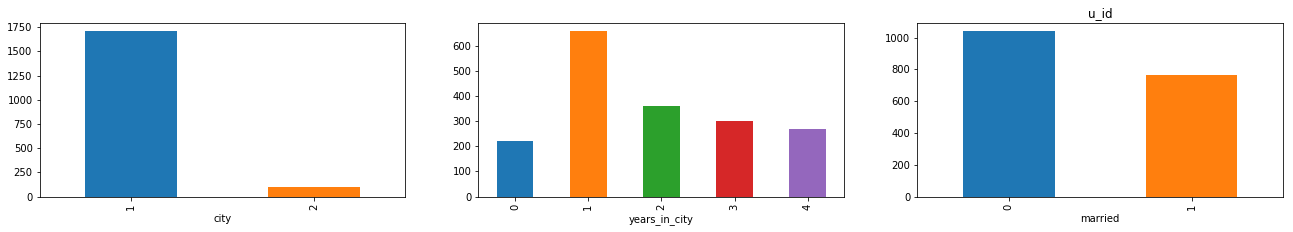

In [42]:
user_clusterdf = pd.read_csv("outputs/user_cluster_assignments.csv")
custom_clusters = create_custom_clusters(user_clusterdf, ['cluster_num'])

for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Cluster Number %s' % temp.iloc[0]['cluster_num'])
    temp['u_id'].groupby(temp['gender']).nunique().plot(kind='bar',ax=axes[0])
    temp['u_id'].groupby(temp['age']).nunique().plot(kind='bar',ax=axes[1])
    temp['u_id'].groupby(temp['occ']).nunique().plot(kind='bar',ax=axes[2])
    plt.show()
print("---------------------------------------------------------------------------------------------------------------------------\n")
for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Cluster Number %s' % temp.iloc[0]['cluster_num'])
    temp['u_id'].groupby(temp['city']).nunique().plot(kind='bar',ax=axes[0])
    temp['u_id'].groupby(temp['years_in_city']).nunique().plot(kind='bar',ax=axes[1])
    temp['u_id'].groupby(temp['married']).nunique().plot(subplots=True,kind='bar',ax=axes[2])
    plt.show()

Cluster Number 0


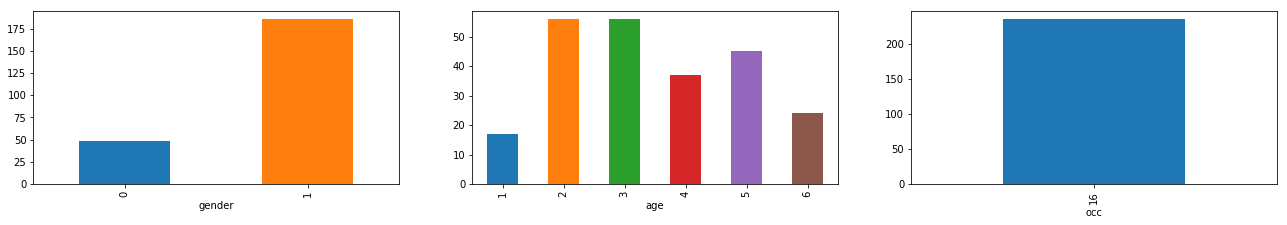

Cluster Number 1


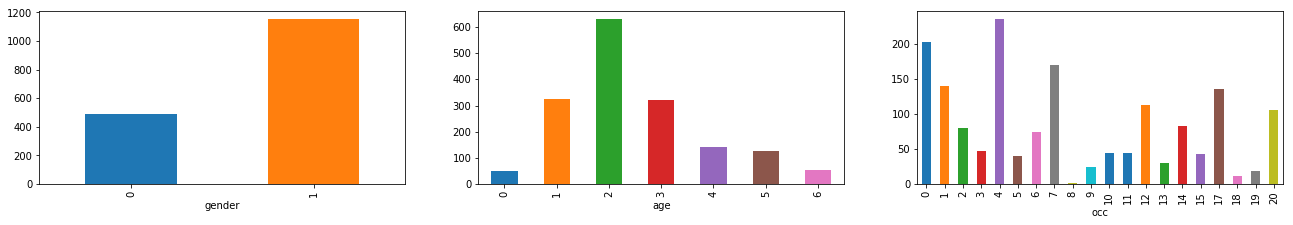

Cluster Number 2


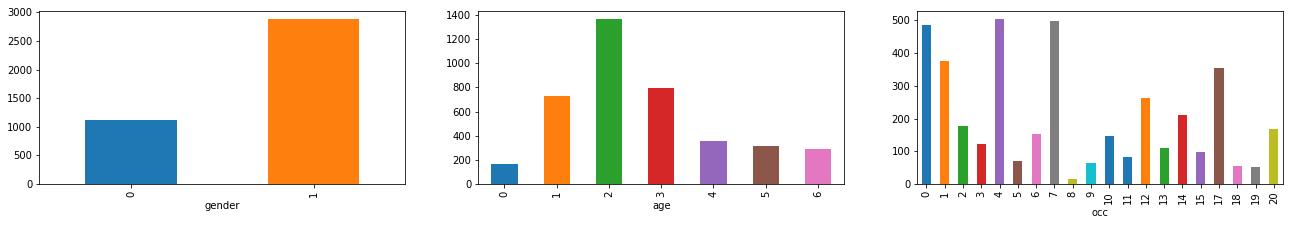

---------------------------------------------------------------------------------------------------------------------------

Cluster Number 0


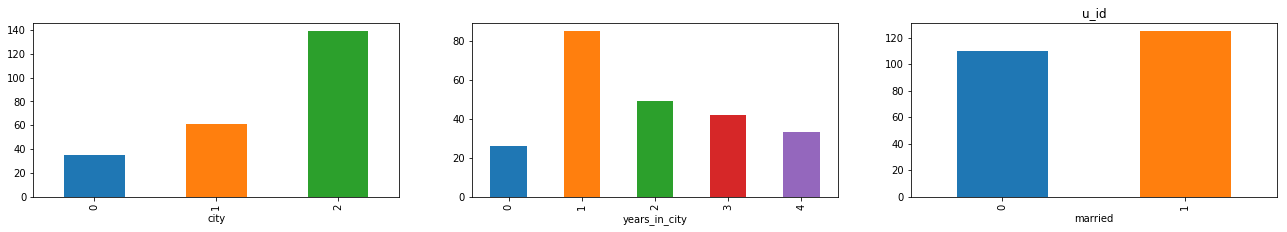

Cluster Number 1


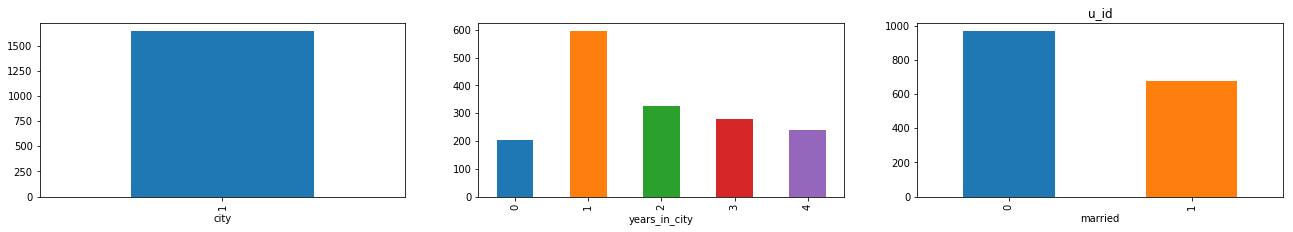

Cluster Number 2


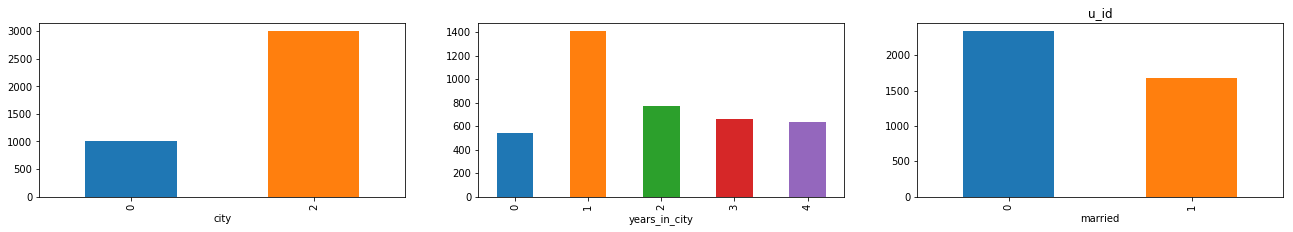

In [43]:
user_clusterdf = pd.read_csv("outputs/user_multi_cluster_assignments.csv")
custom_clusters = create_custom_clusters(user_clusterdf, ['cluster_num'])

for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Cluster Number %s' % temp.iloc[0]['cluster_num'])
    temp['u_id'].groupby(temp['gender']).nunique().plot(kind='bar',ax=axes[0])
    temp['u_id'].groupby(temp['age']).nunique().plot(kind='bar',ax=axes[1])
    temp['u_id'].groupby(temp['occ']).nunique().plot(kind='bar',ax=axes[2])
    plt.show()
print("---------------------------------------------------------------------------------------------------------------------------\n")
for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Cluster Number %s' % temp.iloc[0]['cluster_num'])
    temp['u_id'].groupby(temp['city']).nunique().plot(kind='bar',ax=axes[0])
    temp['u_id'].groupby(temp['years_in_city']).nunique().plot(kind='bar',ax=axes[1])
    temp['u_id'].groupby(temp['married']).nunique().plot(subplots=True,kind='bar',ax=axes[2])
    plt.show()

# Modeling Results

In [44]:
def get_predictions():
    with ZipFile('outputs/xgb_model_and_data.zip', 'r') as zipfile:
        zipfile.extractall()
    print("Found buffer zip file")
    bst = xgb.Booster({'nthread': 4})  # init model
    bst.load_model('outputs/xgb_model.bin') # load model
    dmodel = xgb.DMatrix('outputs/xgb_data.buffer')# load model data
    return bst.predict(dmodel)

In [45]:
def plot_residuals(y_pur, y_actual):
    residuals = y_actual - y_pur

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(121)
    ax1.scatter(y_pur, residuals)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Residual")

    ax2 = fig.add_subplot(122)
    ax2.hist(residuals)
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Frequency")

## Residuals

Found buffer zip file
[04:02:49] 537577x69 matrix with 37092813 entries loaded from outputs/xgb_data.buffer


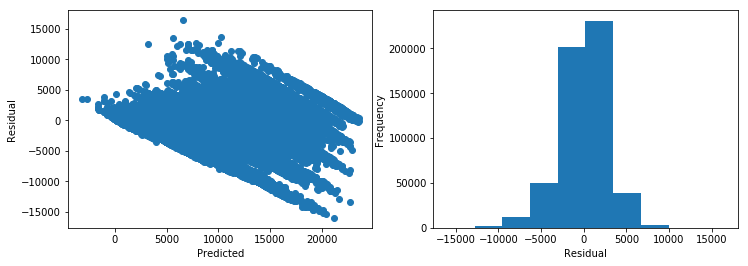

In [46]:
user_clusterdf = pd.read_csv("outputs/user_cluster_assignments.csv")
predictions = get_predictions()
plot_residuals(predictions, user_clusterdf['pur'])

## Feature Importance 

[04:03:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


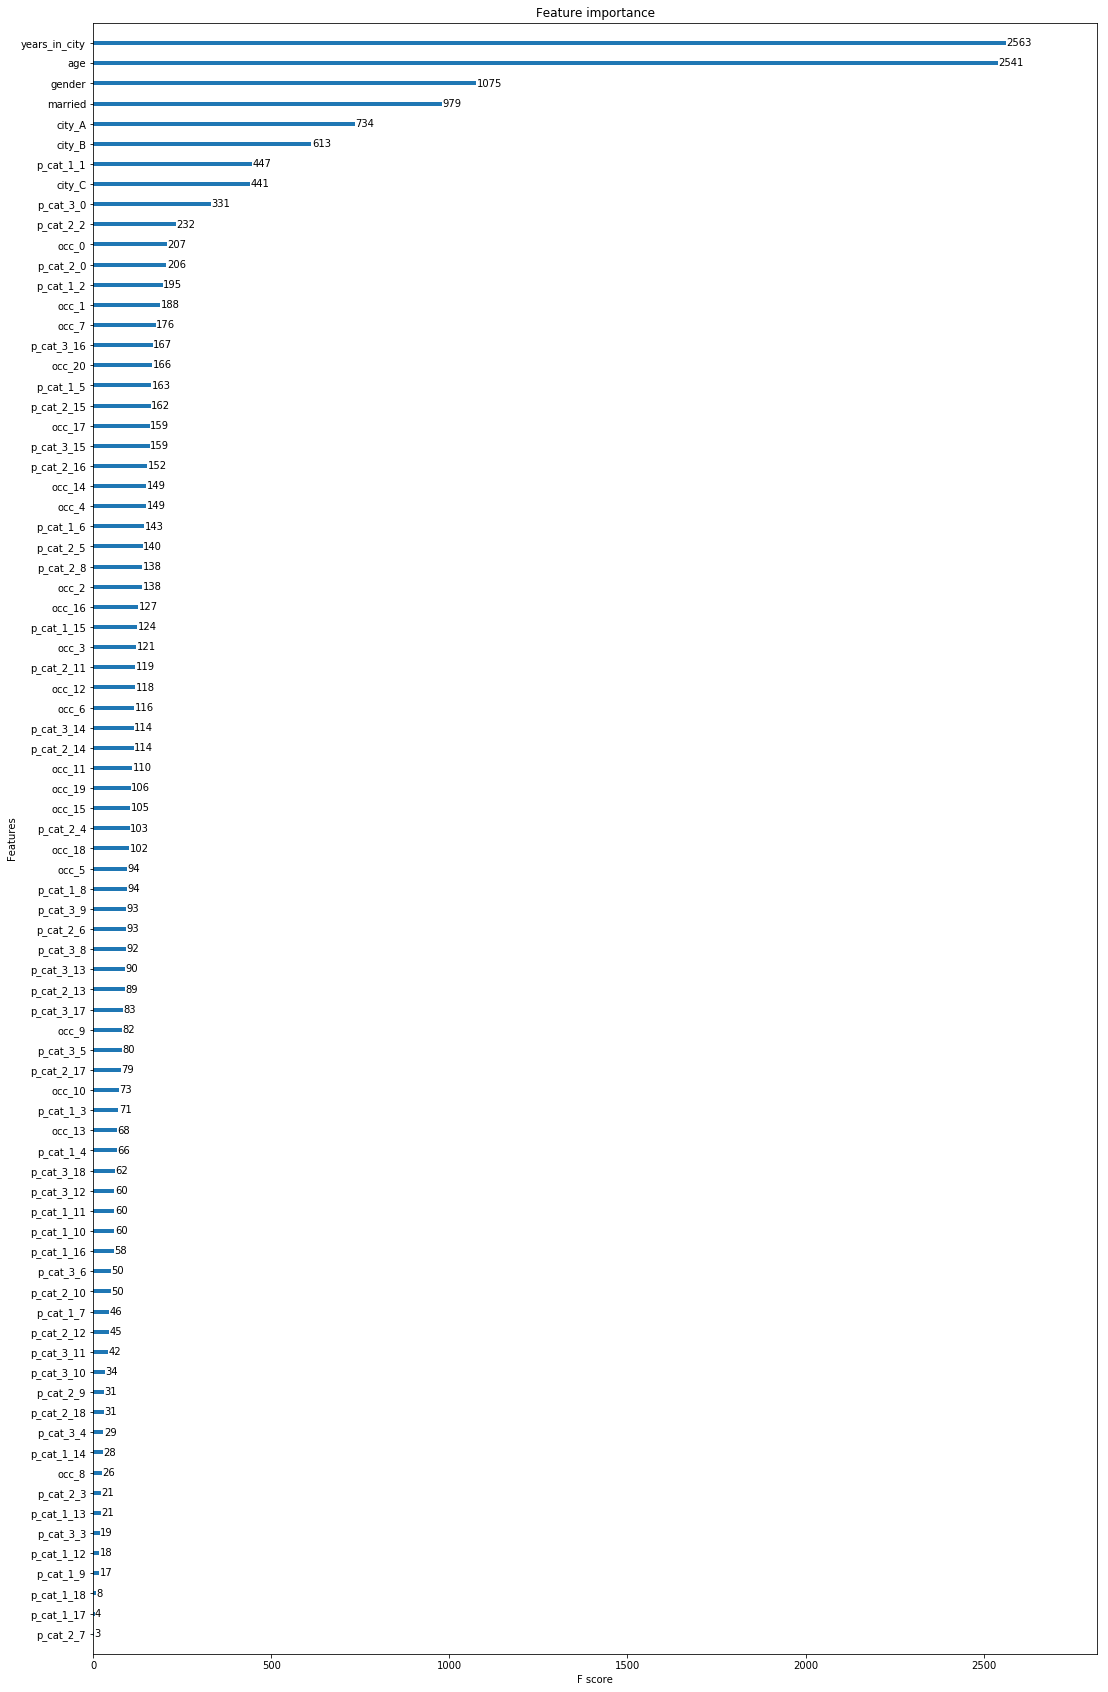

In [47]:
fig, axes = plt.subplots(1, 1, figsize = (18,30))

param = {
        'eta': .75,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'eval_metric': 'rmse',
        'max_depth' : 10,
        'seed': 42}
num_round = 30  # the number of training iterations

_, X_plot, y_plot, _, _ = read_model_dataset(1, combine_cats = False)
dtrain = xgb.DMatrix(X_plot, label = y_plot)
bst = xgb.train(param, dtrain, num_round)

xgb.plot_importance(bst, ax = axes, grid = False)
plt.show()